### Convert images to TFRecords file. 
Refer to https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/convert_to_records.py

In [ ]:
from PIL import Image
import numpy as np
import tensorflow as tf
import os

def _int64_feature(value):
  """Wrapper for inserting int64 features into Example proto."""
  if not isinstance(value, list):
    value = [value]
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))


def _bytes_feature(value):
  """Wrapper for inserting bytes features into Example proto."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def main(data_dir, tfrecords_filename):
    labels = os.listdir(data_dir)
    writer = tf.python_io.TFRecordWriter(tfrecords_filename)
    for label in labels:
        path = os.path.join(data_dir, label)
        img_files = os.listdir(path)
        for file in img_files:
            # The reason to store image sizes was demonstrated
            # in the previous example -- we have to know sizes
            # of images to later read raw serialized string,
            # convert to 1d array and convert to respective
            # shape that image used to have.
            img_path = os.path.join(path, file)
            img = np.array(Image.open(img_path))
            height = img.shape[0]
            width = img.shape[1]
            img_raw = img.tostring()

            example = tf.train.Example(features=tf.train.Features(feature={
            'height': _int64_feature(height),
            'width': _int64_feature(width),
            'image_raw': _bytes_feature(img_raw),
            'label': _int64_feature(int(label))}))
            writer.write(example.SerializeToString())
    writer.close()

if __name__ == '__main__':
    data_dir = './tempimg'
    tfrecords_filename = 'validation.tfrecords'
    main(data_dir = data_dir, tfrecords_filename = tfrecords_filename)

### Feed images from TFRecords file randomly
Refer to: https://github.com/tensorflow/tensorflow/blob/master/tensorflow/examples/how_tos/reading_data/fully_connected_reader.py

2 (2, 244, 244, 3) (2,)
current batch


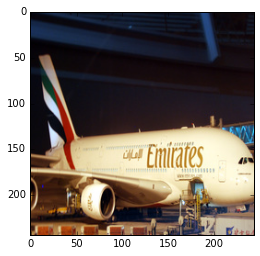

0


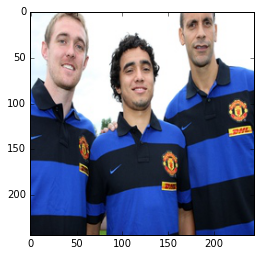

1
current batch


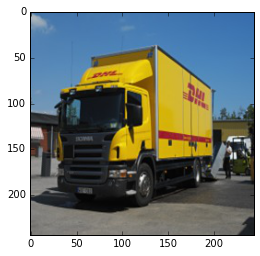

1


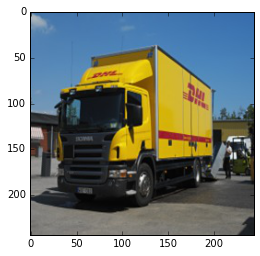

1
current batch


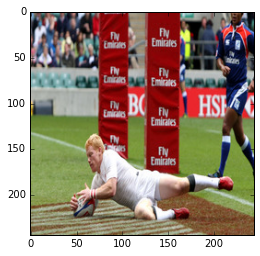

0


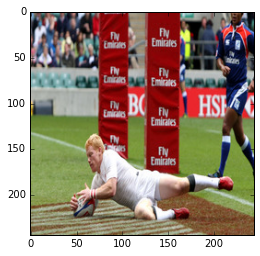

0
current batch


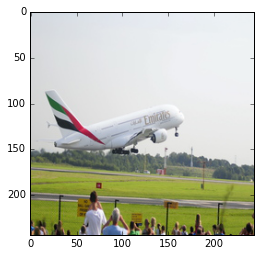

0


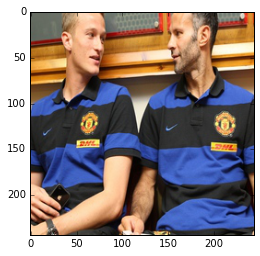

1
current batch


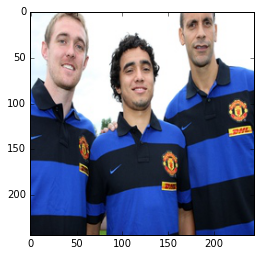

1


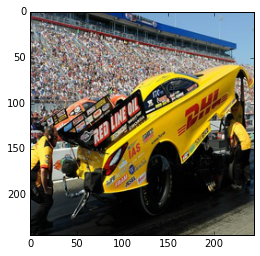

1
current batch


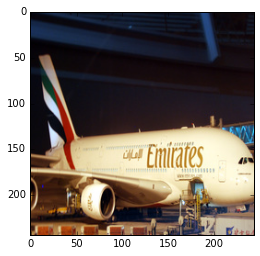

0


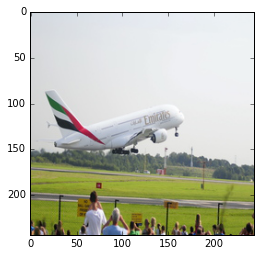

0
current batch


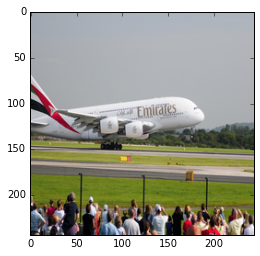

0


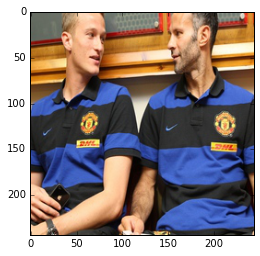

1
current batch


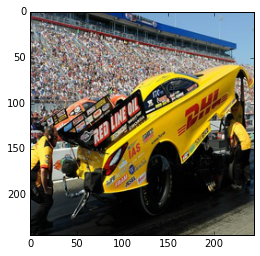

1


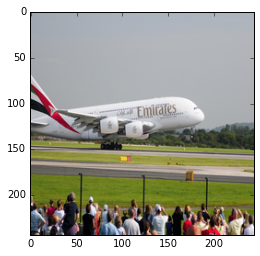

0
Done for 2 epochs


In [15]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from __future__ import print_function
filename = 'validation.tfrecords'

SIZE = 244

def read_and_decode(filename):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename)
    features = tf.parse_single_example(serialized_example, 
        features = {
        'height': tf.FixedLenFeature([],tf.int64), 
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)})
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = tf.pack([height, width, 3])
    image = tf.reshape(image, image_shape)
    # resize image for the nets
    resized_image = tf.image.resize_image_with_crop_or_pad(image, SIZE, SIZE)
    # resized_image = tf.image.resize_images(resized_image, [SIZE, SIZE],align_corners=True)
    images, labels = tf.train.shuffle_batch([resized_image, label], shapes = [(SIZE,SIZE,3),()],
                                            batch_size = 2, capacity = 300, 
                                            # num_threads=2, 
                                            min_after_dequeue = 10)
    print (2, images.get_shape(), labels.get_shape())
    return images, labels

filename_queue = tf.train.string_input_producer([filename], num_epochs=2)
image, label = read_and_decode(filename_queue)
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())

with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    try:
        while not coord.should_stop():
            img, lab = sess.run([image, label])
            # print img[0,:,:,:].get_shape()
            print ('current batch')
            plt.imshow(img[0, :, :, :])

            plt.show()
            print (lab[0])
            plt.imshow(img[1, :, :, :])
            plt.show()
            print (lab[1])
    except tf.errors.OutOfRangeError:
        print('Done for %d epochs'%2)
    finally:
        coord.request_stop()
        coord.join(threads)

In [1]:
import tensorflow as tf
print tf.__version__

0.12.1


### make a simple network running

current batch


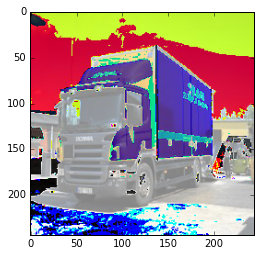

1


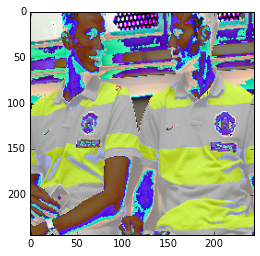

1
current batch


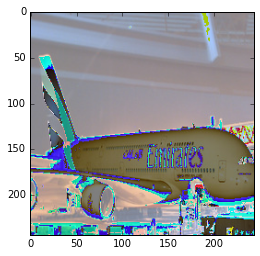

0


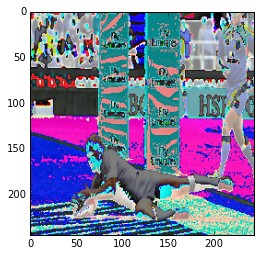

0
current batch


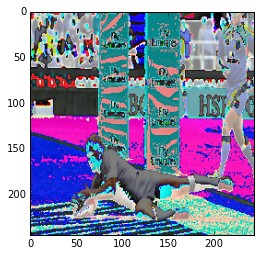

0


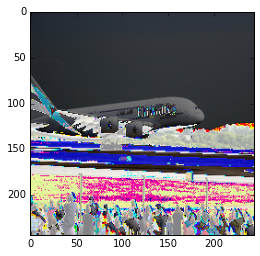

0
current batch


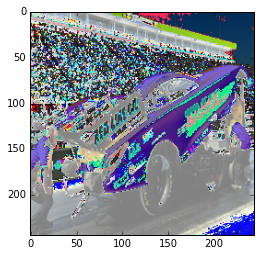

1


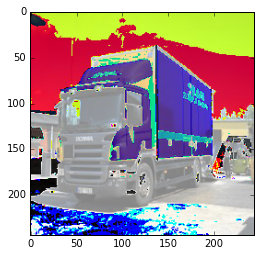

1
current batch


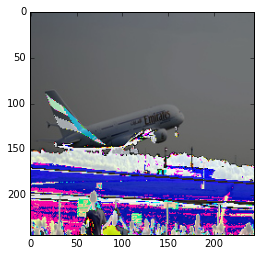

0


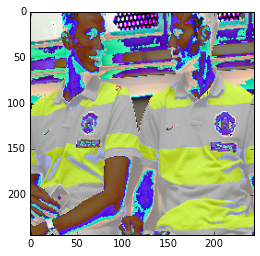

1
current batch


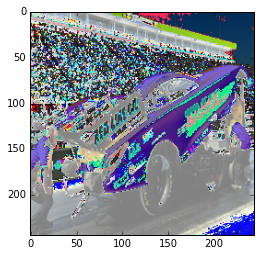

1


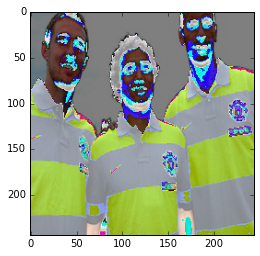

1
current batch


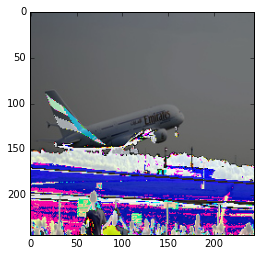

0


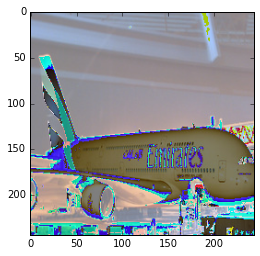

0
current batch


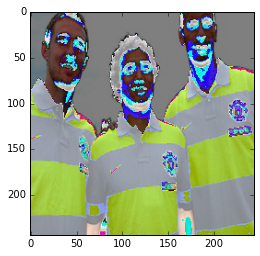

1


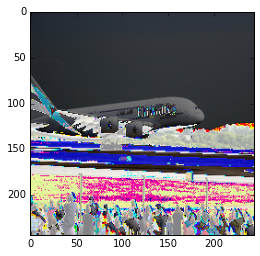

0
Done for 2 epochs


In [25]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
from __future__ import print_function
filename = 'validation.tfrecords'

SIZE = 244

def read_and_decode(filename):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename)
    features = tf.parse_single_example(serialized_example, 
        features = {
        'height': tf.FixedLenFeature([],tf.int64), 
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)})
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = tf.pack([height, width, 3])
    image = tf.reshape(image, image_shape)
    # resize image for the nets
    resized_image = tf.image.resize_image_with_crop_or_pad(image, SIZE, SIZE)
    resized_image = tf.cast(resized_image, tf.float32) * (1. / 255) - 0.5
    # resized_image = tf.image.resize_images(resized_image, [SIZE, SIZE],align_corners=True)
    return resized_image, label

def inputs():
    filename = 'validation.tfrecords'
    filename_queue = tf.train.string_input_producer([filename], num_epochs=2)
    image, label = read_and_decode(filename_queue)
    images, labels = tf.train.shuffle_batch([image, label], shapes = [(SIZE,SIZE,3),()],
                                            batch_size = 2, capacity = 300, 
                                            # num_threads=2, 
                                            min_after_dequeue = 10)
    return images, labels
    

def inference (inputs, num_classes):
#     full = 'tensorflow.contrib.slim.python.slim.nets.' + 'vgg.vgg_16'
#     # e.g. full == 'tensorflow.contrib.slim.python.slim.nets.vgg.vgg_a'
#     fs = full.split('.')
#     loader = pkgutil.find_loader('.'.join(fs[:-1]))
#     module = loader.load_module('')
#     net = getattr(module, fs[-1])
    return net.vgg.vgg_16(inputs, num_classes)

def fcn_loss (logits, labels):
    with tf.name_scope('loss'):
        labels = tf.to_int32(labels)    # float from picpac
        xe = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits, name='xentropy')
        hit = tf.cast(tf.nn.in_top_k(logits, labels, 1, name="accuracy"), tf.float32)
        return [tf.reduce_mean(xe, name='xentropy_mean'), tf.reduce_mean(hit, name='accuracy_total')]
    pass

with tf.Graph().as_default():
    # Input images and labels.
    images, labels = inputs()
    predictions, _ = inference(images, FLAGS.num_classes)
    loss, accurate = fcn_loss(predictions, labels)

    # Specify the optimization scheme:
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate)
    # create_train_op that ensures that when we evaluate it to get the loss,
    # the update_ops are done and the gradient updates are computed.
    # train_op = slim.learning.create_train_op(loss, optimizer)
    train_op = optimizer.minimize(loss)
    init_op = tf.group(tf.global_variables_initializer(),
                       tf.local_variables_initializer())
    with tf.Session() as sess:
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        try:
            while not coord.should_stop():
                img, lab = sess.run([images, labels])
                # print img[0,:,:,:].get_shape()
                print ('current batch')
                plt.imshow(img[0, :, :, :])

                plt.show()
                print (lab[0])
                plt.imshow(img[1, :, :, :])
                plt.show()
                print (lab[1])
        except tf.errors.OutOfRangeError:
            print('Done for %d epochs'%2)
        finally:
            coord.request_stop()
            coord.join(threads)

Step 0: loss = 0.69 (4.242 sec)
Done training for 2 epochs, 4 steps.


SystemExit: 

To exit: use 'exit', 'quit', or Ctrl-D.


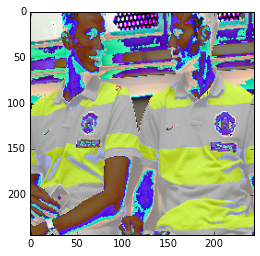

In [29]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
import time
import argparse
import sys
# import pkgutil
import tensorflow.contrib.slim.nets as net
#> import tensorflow.contrib.slim.nets <
def read_and_decode(filename):
    reader = tf.TFRecordReader()
    _,serialized_example = reader.read(filename)
    features = tf.parse_single_example(serialized_example, 
        features = {
        'height': tf.FixedLenFeature([],tf.int64), 
        'width': tf.FixedLenFeature([], tf.int64),
        'image_raw': tf.FixedLenFeature([], tf.string),
        'label': tf.FixedLenFeature([], tf.int64)})
    image = tf.decode_raw(features['image_raw'], tf.uint8)
    label = tf.cast(features['label'], tf.int32)
    height = tf.cast(features['height'], tf.int32)
    width = tf.cast(features['width'], tf.int32)

    image_shape = tf.pack([height, width, 3])
    image = tf.reshape(image, image_shape)
    # resize image for the nets
    resized_image = tf.image.resize_image_with_crop_or_pad(image, FLAGS.img_size, FLAGS.img_size)
    resized_image = tf.cast(resized_image, tf.float32) * (1. / 255) - 0.5
    # resized_image = tf.image.resize_images(resized_image, [SIZE, SIZE],align_corners=True)
    return resized_image, label

def inputs(train):
    filename = 'validation.tfrecords'
    with tf.name_scope('input'):
        filename_queue = tf.train.string_input_producer([filename], num_epochs=FLAGS.num_epochs)
        image, label = read_and_decode(filename_queue)
        images, labels = tf.train.shuffle_batch([image, label], shapes = [(FLAGS.img_size, FLAGS.img_size,3),()],
                                                batch_size = FLAGS.batch_size, capacity = 300, 
                                                num_threads=1, 
                                                min_after_dequeue = 1)
        # to use softmax_crossentropy loss function, we need to encode labels to one hot.
        # labels = tf.one_hot(labels, depth=FLAGS.num_classes, on_value=1.0, off_value=0.0, axis= -1)
        return images, labels

def inference (inputs, num_classes):
#     full = 'tensorflow.contrib.slim.python.slim.nets.' + 'vgg.vgg_16'
#     # e.g. full == 'tensorflow.contrib.slim.python.slim.nets.vgg.vgg_a'
#     fs = full.split('.')
#     loader = pkgutil.find_loader('.'.join(fs[:-1]))
#     module = loader.load_module('')
#     net = getattr(module, fs[-1])
    return net.vgg.vgg_16(inputs, num_classes)

def fcn_loss (logits, labels):
    with tf.name_scope('loss'):
        labels = tf.to_int32(labels)    # float from picpac
        xe = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels, logits=logits, name='xentropy')
        hit = tf.cast(tf.nn.in_top_k(logits, labels, 1, name="accuracy"), tf.float32)
        return [tf.reduce_mean(xe, name='xentropy_mean'), tf.reduce_mean(hit, name='accuracy_total')]
    pass

def run_training():
    # use VGG model
    slim = tf.contrib.slim
    # vgg = tf.contrib.slim.nets.vgg
    # Tell TensorFlow that the model will be built into the default Graph.
    with tf.Graph().as_default():
        # Input images and labels.
        images, labels = inputs(train=True)
        # define the model
        # predictions = vgg.vgg16(images, is_training=True)
        predictions, _ = inference(images, FLAGS.num_classes)
        # Specify the loss function:
        # loss = slim.losses.softmax_cross_entropy(predictions, labels)
        loss, accurate = fcn_loss(predictions, labels)

        # Specify the optimization scheme:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=FLAGS.learning_rate)
        # create_train_op that ensures that when we evaluate it to get the loss,
        # the update_ops are done and the gradient updates are computed.
        # train_op = slim.learning.create_train_op(loss, optimizer)
        train_op = optimizer.minimize(loss)

        # The op for initializing the variables.
        init_op = tf.group(tf.global_variables_initializer(),
                           tf.local_variables_initializer())

        with tf.Session() as sess:
            sess.run(init_op)
            # Start input enqueue threads.
            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)
            try:
                step = 0
                while not coord.should_stop():
                    start_time = time.time()
                    _, loss_value = sess.run([train_op, loss])
                    duration = time.time() - start_time

                    # Print an overview fairly often.
                    if step % 100 == 0:
                        print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value,
                                                                 duration))
                    step += 1
            except tf.errors.OutOfRangeError:
                print('Done training for %d epochs, %d steps.' % (FLAGS.num_epochs, step))
            finally:
                # When done, ask the threads to stop.
                coord.request_stop()
                # Wait for threads to finish.
                coord.join(threads)


def main(_):
    run_training()

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument('--learning_rate', type=float, default=0.01, help='Initial learning rate')
    parser.add_argument('--num_epochs', type=int, default=2, help='Number of epochs to run trainer')
    parser.add_argument('--batch_size', type=int, default=2, help='batch size')
    parser.add_argument('--img_size', type=int, default=244, help='image size')
    parser.add_argument('--num_classes', type=int, default=2, help='number of classes')
    FLAGS, unparsed = parser.parse_known_args()
    tf.app.run()